# Graphical Models: Similarity Distribution Experimentation

In [1]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import random

## Similarity Implementations

### General Methods

In [2]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [3]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [4]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [5]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [6]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [7]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [58]:
# helper func to calculate the union using method 2
def calculate_union_2(graph, children_a, children_b):
    union = 0
    for i in children_a:
        if i in children_b:
            union += abs(children_a[i] - children_b[i])
        else:
            union += children_a[i]
        print(union)
    for i in children_b:
        if not i in children_a:
            union += children_b[i]
        print(union)
    return union

In [60]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(graph, node_a, {})
    children_b = get_all_children(graph, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union_1 = calculate_union_1(graph, children_a, children_b)
    union_2 = calculate_union_2(graph, children_a, children_b)
    if union_1 == 0:
        total_1 = 0
    else:
        total_1 = intersection/union_1
    if union_2 == 0:
        total_2 = 0
    else:
        total_2 = intersection/union_2
    results = {"method 1": total_1, "method 2": total_2}
    return results

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [10]:
# Returns the similarity of node B compared to node A, based on 
# children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    
    return cost / len(A_children)

In [11]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [12]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    return cost / len(A_children)

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [13]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [14]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [15]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [16]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [17]:
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        while (child == parent):
            child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
    
    return gm

In [18]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [43]:
def makeDirectedPath(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = weight=random.uniform(0, 1)
    return pdg

def makeDirectedPathOne(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = 1
    return pdg

In [20]:
def makeDirectedStarGraph(num_nodes):
    sdg = nx.DiGraph()
    sdg.add_node(0)
    for i in range(1, num_nodes+1):
        sdg.add_node(i)
        sdg.add_edge(0, i, weight=random.uniform(0, 1))
    return sdg

## Experiment Setup

### make directed graph

In [21]:
g = makeDirectedGraph(3, 3)

In [22]:
nx.edges(g)

OutEdgeView([(0, 1), (1, 2)])

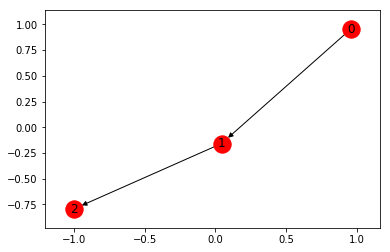

In [23]:
nx.draw_networkx(g)

In [24]:
nx.get_edge_attributes(g, 'weight')

{(0, 1): 0.3647092559576207, (1, 2): 0.8244685571642975}

### make directed path

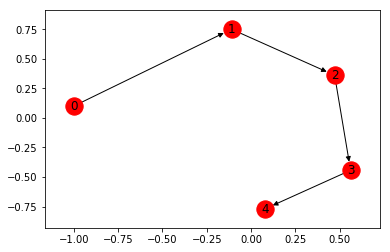

In [25]:
pdg = makeDirectedPath(5)
nx.draw_networkx(pdg)

In [26]:
nx.get_edge_attributes(pdg, 'weight')

{(0, 1): 0.227742306671309,
 (1, 2): 0.7312246392563446,
 (2, 3): 0.5907162357493008,
 (3, 4): 0.8237777247238401}

### make directed star graph

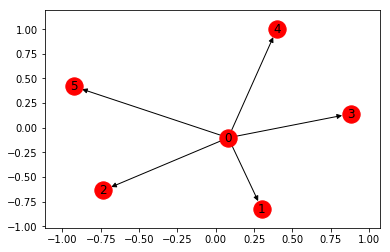

In [27]:
sdg = makeDirectedStarGraph(5)
nx.draw_networkx(sdg)

In [28]:
nx.get_edge_attributes(sdg, 'weight')

{(0, 1): 0.9254943717713601,
 (0, 2): 0.6536522682632205,
 (0, 3): 0.5763116126500251,
 (0, 4): 0.4956863860730244,
 (0, 5): 0.17094681096677122}

### Random tree : WIP

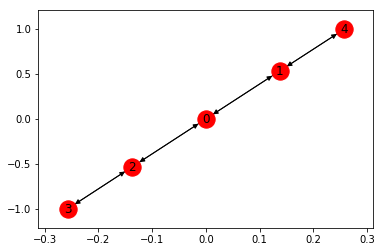

In [29]:
tg = nx.random_tree(5, seed=None)
nx.draw_networkx(tg.to_directed())

## Tests

1. In this first test, we will create a path (of length 5) and a start graph (with 5 total nodes) and compute the similarity of the center node compared with all of the other nodes.

In [54]:
pdg = makeDirectedPath(5)

In [55]:
nx.get_edge_attributes(pdg, 'weight')

{(0, 1): 0.7053233823911597,
 (1, 2): 0.5001706049002577,
 (2, 3): 0.8453133881825011,
 (3, 4): 0.8310306490724966}

In [37]:
nx.get_edge_attributes(sdg, 'weight')

{(0, 1): 0.9254943717713601,
 (0, 2): 0.6536522682632205,
 (0, 3): 0.5763116126500251,
 (0, 4): 0.4956863860730244,
 (0, 5): 0.17094681096677122}

In [59]:
calculate_similarity(pdg, 0, 1)

0.7053233823911597
0.8527119644705352
0.8527119644705352
0.8527119644705352
0.8527119644705352
0.8527119644705352
0.8527119644705352


{'method 1': 0.634151080817282, 'method 2': 1.7333687420313644}

In [39]:
for i in sdg.nodes():
    print(i, calculate_similarity(sdg, 0, i))

0 {'method 1': 1.0, 'method 2': 0}
1 {'method 1': 0.0, 'method 2': 0.0}
2 {'method 1': 0.0, 'method 2': 0.0}
3 {'method 1': 0.0, 'method 2': 0.0}
4 {'method 1': 0.0, 'method 2': 0.0}
5 {'method 1': 0.0, 'method 2': 0.0}


Well, of course any two nodes in a star graph will have no similarity. This makes sense. 

2. In this test we will see why method 2 is getting a similarity score (sometimes) of greater than 1.

In [131]:
pdg = makeDirectedPath(3)
for i in pdg.nodes():
    print(i, calculate_similarity(pdg, 0, i))

0 {'method 1': 1.0, 'method 2': 0}
1 {'method 1': 0.4048769003305451, 'method 2': 0.6803246262082971}
2 {'method 1': 0.0, 'method 2': 0.0}


In [132]:
pdg = makeDirectedPath(4)
for i in pdg.nodes():
    print(i, calculate_similarity(pdg, 0, i))

0 {'method 1': 1.0, 'method 2': 0}
1 {'method 1': 0.39157331004218054, 'method 2': 0.6435833872924398}
2 {'method 1': 0.12475933746454909, 'method 2': 0.1425428945487274}
3 {'method 1': 0.0, 'method 2': 0.0}


In [133]:
pdg = makeDirectedPath(5)
for i in pdg.nodes():
    print(i, calculate_similarity(pdg, 0, i))

0 {'method 1': 1.0, 'method 2': 0}
1 {'method 1': 0.13978453288245202, 'method 2': 0.16249944139094458}
2 {'method 1': 0.05997827443131737, 'method 2': 0.06380520024155023}
3 {'method 1': 0.010720069702112657, 'method 2': 0.01083623489550089}
4 {'method 1': 0.0, 'method 2': 0.0}


In [44]:
pdg = makeDirectedPathOne(100)
method_1_nums = []
method_2_nums = []
for i in pdg.nodes():
    sim = calculate_similarity(pdg, 0, i)
    #print(i, sim)
    method_1_nums.append(sim['method 1'])
    method_2_nums.append(sim['method 2'])

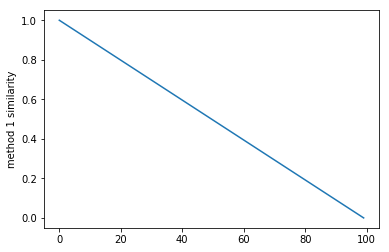

In [45]:
import matplotlib.pyplot as plt
plt.plot(method_1_nums)
plt.ylabel("method 1 similarity")
plt.show()

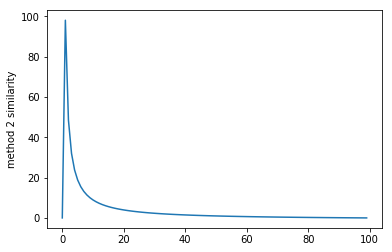

In [46]:
plt.plot(method_2_nums)
plt.ylabel("method 2 similarity")
plt.show()

### Export a file to excel

In [145]:
sim

{'method 1': 0.0, 'method 2': 0.0}

In [151]:
import pandas as pd
df = pd.DataFrame({'method 1': method_1_nums, 'method 2': method_2_nums }, columns = ['method 1', 'method 2'])
df.to_excel(r'testfile.xlsx', index = False, header=True)